# Generating Music
MGSC-695 Project

We are using beethoven music converted in MIDI files to generate music.
We have adapted the code from here [link](https://www.analyticsvidhya.com/blog/2020/01/how-to-perform-automatic-music-generation) to fit with our desired music creation

In [ ]:
# Libraries to be used
import random

from music21 import *  # understanding music
import os  # for listing down the file names
import numpy as np  # array processing
from collections import Counter
import matplotlib.pyplot as plt  # Visualisation

## Reading the MIDI Files
Understanding the MIDI format: [midi](https://www.cs.cmu.edu/~music/cmsip/readings/MIDI%20tutorial%20for%20programmers.html)
- Convert the MIDI file into an array of notes
- To simplify the training.  Only the piano channel is selected.

In [2]:
# defining function to read MIDI files
def read_midi(file):
    
    print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    # Parsing a midi file
    midi = converter.parse(file)
  
    # Grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    # Looping over all the instruments
    for part in s2.parts:
    
        #select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 
      
            #finding whether a particular element is note or a chord
            for element in notes_to_parse:
                #note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                #chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

Transform Beethoven Midi files to numpy array

In [3]:
#specify the path
path='Beethoven/'

#read all the filenames
files=[i for i in os.listdir(path) if i.endswith(".mid")]

#reading each midi file
notes_array = np.array([read_midi(path+i) for i in files])

Loading Music File: Beethoven/beethoven_opus10_1.mid
Loading Music File: Beethoven/beethoven_opus10_2.mid
Loading Music File: Beethoven/beethoven_opus10_3.mid
Loading Music File: Beethoven/beethoven_opus22_1.mid
Loading Music File: Beethoven/beethoven_opus22_2.mid
Loading Music File: Beethoven/beethoven_opus22_3.mid
Loading Music File: Beethoven/beethoven_opus22_4.mid


C:\Users\SAMUEL~1\AppData\Local\Temp/ipykernel_25940/3579340400.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  notes_array = np.array([read_midi(path+i) for i in files])


Appending all the notes together to create a 1D array

In [4]:
#converting 2D array into 1D array
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print(len(unique_notes))

225


## Analyzing Occurence Frequency of Notes from the Dataset

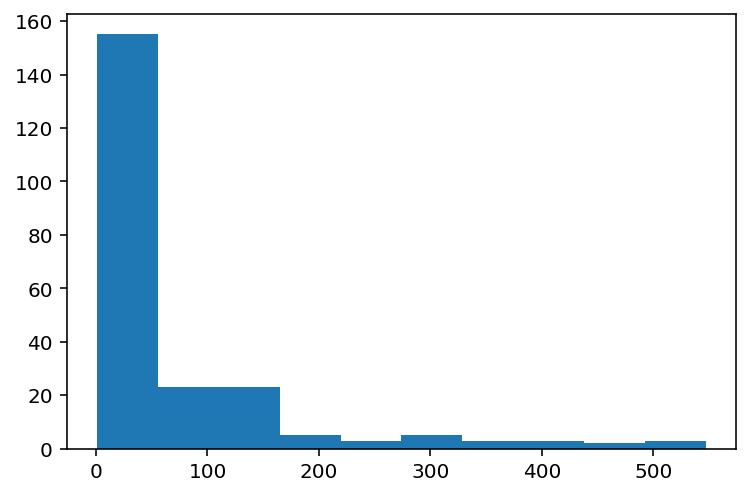

In [5]:
#computing frequency of each note
freq = dict(Counter(notes_))

#consider only the frequencies
no=[count for _,count in freq.items()]

#plot
plt.hist(no)
plt.show()

In [6]:
frequent_notes = [note_ for note_, count in freq.items() if count>=50]
print(len(frequent_notes))

75


## Create the training dataset with 32 timesteps of music notes
- This will create a training dataset of size (nb notes x timestep of 32)

Assign a unique integer to all the notes and chords instead of the music notation.

In [7]:
unique_notes = np.unique(notes_)
note_to_int = dict((note_, number) for number, note_ in enumerate(unique_notes))

notes_array_int = []
for i in notes_array:
    temp = []
    for j in i:
        temp.append(note_to_int[j])
    notes_array_int.append(np.array(temp))

Creating the x and y datasets based on the timestep size

In [8]:
no_of_timesteps = 32
x = []
y = []

for note_ in notes_array_int:
    for i in range(0, len(note_) - no_of_timesteps):
        
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)
        
x=np.array(x)
y=np.array(y)

Create the training and test set

In [11]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x,y,test_size=0.2,random_state=0)

ImportError: cannot import name 'moduleTNC' from partially initialized module 'scipy.optimize' (most likely due to a circular import) (C:\Anaconda\lib\site-packages\scipy\optimize\__init__.py)

def lstm():
    model = Sequential()
    model.add(LSTM(128,return_sequences=True))
    model.add(LSTM(128))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
    return model

## Creating a Wavenet Model

From the research article, we can adapt the wavenet model with our notes/chords data to generate music.  Original paper used for the following images: [link](https://www.deepmind.com/blog/wavenet-a-generative-model-for-raw-audio)



We start by building the causal dilated convolutianal layers like the following:

![image](dilated_causal_convolutianal_layers.png)

The full architecture of the wavenet model is similar to this except the residual and skip connections are not used.:

![image](wavenet_architecture.png)

The first model developed is essentially just the dilated causal convolutional layer.


In [46]:
# Tensorflow Keras Libraries
from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K

K.clear_session()

# ---- MODEL CREATION -----
model = Sequential()
    
# The embedding layer creates a dense vector of size (batch, no_of_timesteps, embedding_size)
# Weights of the vector are trained during the training process.
# The embedding layer allows to learn relationship between notes and chords and is used normally in the natural language processing domain.
embedding_size = 100
model.add(Embedding(input_dim=len(unique_notes), output_dim=embedding_size, input_length=no_of_timesteps,trainable=True, embeddings_initializer='uniform'))

# Creating the causal dilated convolutional layers
# First layer
model.add(Conv1D(filters=64, kernel_size=3, padding='causal', dilation_rate=1, activation='relu', ))
model.add(Dropout(rate=0.2))
model.add(MaxPool1D(pool_size=2, padding='valid'))

# Second layer
model.add(Conv1D(filters=128, kernel_size=3, activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(rate=0.2))
model.add(MaxPool1D(pool_size=2, padding='valid'))

# Third layer
model.add(Conv1D(filters=256, kernel_size=3, activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(rate=0.2))
model.add(MaxPool1D(pool_size=2, padding='valid'))
          
# Downsample the input by taking hte maximum value
model.add(GlobalMaxPool1D())
    
model.add(Dense(256, activation='relu', ))
model.add(Dense(len(unique_notes), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 50)            11250     
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 64)            9664      
_________________________________________________________________
dropout (Dropout)            (None, 32, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 128)           24704     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 128)            0

In [43]:
# Create a callback to retain only the best model
mc=ModelCheckpoint('best_model_depth1', monitor='val_loss', mode='min', save_best_only=True,verbose=1)

In [47]:
history = model.fit(x_tr, y_tr,batch_size=128,epochs=20, validation_data=(x_val,y_val),verbose=1, callbacks=[mc])

Epoch 1/20
91/93 [============================>.] - ETA: 0s - loss: 4.6146
Epoch 00001: val_loss did not improve from 3.01595
93/93 [==============================] - 3s 28ms/step - loss: 4.6132 - val_loss: 4.5287
Epoch 2/20
91/93 [============================>.] - ETA: 0s - loss: 4.3961
Epoch 00002: val_loss did not improve from 3.01595
93/93 [==============================] - 2s 25ms/step - loss: 4.3928 - val_loss: 4.3450
Epoch 3/20
92/93 [============================>.] - ETA: 0s - loss: 4.1265
Epoch 00003: val_loss did not improve from 3.01595
93/93 [==============================] - 3s 28ms/step - loss: 4.1251 - val_loss: 4.1790
Epoch 4/20
92/93 [============================>.] - ETA: 0s - loss: 3.8951
Epoch 00004: val_loss did not improve from 3.01595
93/93 [==============================] - 2s 26ms/step - loss: 3.8965 - val_loss: 3.9989
Epoch 5/20
91/93 [============================>.] - ETA: 0s - loss: 3.7427
Epoch 00005: val_loss did not improve from 3.01595
93/93 [===========

## Increase depth of convolution network
- Other articles show that more depth in the convolution layers and starting with smaller filter size helps to increase the quality of the music generation. See this [article](https://towardsdatascience.com/generating-piano-music-with-dilated-convolutional-neural-networks-d81d02e1dda6)

In [221]:
K.clear_session()

# ---- MODEL CREATION -----
model2 = Sequential()

# The embedding layer creates a dense vector of size (batch, no_of_timesteps, embedding_size)
# Weights of the vector are trained during the training process.
# The embedding layer allows to learn relationship between notes and chords and is used normally in the natural language processing domain.
embedding_size = 100
model2.add(Embedding(input_dim=len(unique_notes), output_dim=embedding_size, input_length=no_of_timesteps,trainable=True, embeddings_initializer='uniform'))

# Creating the causal dilated convolutional layers
# ------ ADDED LAYERS --------
# LAYER 0.1
model2.add(Conv1D(filters=16, kernel_size=3, padding='causal', dilation_rate=1, activation='relu', ))
model2.add(Dropout(rate=0.1))
model2.add(MaxPool1D(pool_size=2, padding='valid'))

# 0.2
model2.add(Conv1D(filters=32, kernel_size=3, padding='causal', dilation_rate=1, activation='relu', ))
model2.add(Dropout(rate=0.1))
model2.add(MaxPool1D(pool_size=2, padding='valid'))

# ------------------------------------
# First layer
model2.add(Conv1D(filters=64, kernel_size=3, padding='causal', dilation_rate=1, activation='relu', ))
model2.add(Dropout(rate=0.2))
model2.add(MaxPool1D(pool_size=2, padding='valid'))

# Second layer
model2.add(Conv1D(filters=128, kernel_size=3, activation='relu',dilation_rate=2,padding='causal'))
model2.add(Dropout(rate=0.2))
model2.add(MaxPool1D(pool_size=2, padding='valid'))

# Third layer
model2.add(Conv1D(filters=256, kernel_size=3, activation='relu',dilation_rate=4,padding='causal'))
model2.add(Dropout(rate=0.2))
model2.add(MaxPool1D(pool_size=2, padding='valid'))

# Downsample the input by taking hte maximum value
model2.add(GlobalMaxPool1D())

model2.add(Dense(256, activation='relu', ))
model2.add(Dense(len(unique_notes), activation='softmax'))

model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           22500     
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 16)            4816      
_________________________________________________________________
dropout (Dropout)            (None, 32, 16)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 32)            1568      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 32)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 32)             0

In [222]:
# Run the model and save the best model
mc = ModelCheckpoint('best_model_depth2', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
history = model2.fit(x_tr, y_tr, batch_size=128, epochs=20, validation_data=(x_val, y_val), verbose=1, callbacks=[mc])

Epoch 1/20
91/93 [============================>.] - ETA: 0s - loss: 4.6444
Epoch 00001: val_loss improved from inf to 4.52399, saving model to best_model_depth2
INFO:tensorflow:Assets written to: best_model_depth2\assets
93/93 [==============================] - 4s 41ms/step - loss: 4.6410 - val_loss: 4.5240
Epoch 2/20
91/93 [============================>.] - ETA: 0s - loss: 4.4403
Epoch 00002: val_loss improved from 4.52399 to 4.52077, saving model to best_model_depth2
INFO:tensorflow:Assets written to: best_model_depth2\assets
93/93 [==============================] - 4s 42ms/step - loss: 4.4390 - val_loss: 4.5208
Epoch 3/20
91/93 [============================>.] - ETA: 0s - loss: 4.4040
Epoch 00003: val_loss did not improve from 4.52077
93/93 [==============================] - 2s 22ms/step - loss: 4.4064 - val_loss: 4.5435
Epoch 4/20
91/93 [============================>.] - ETA: 0s - loss: 4.3563
Epoch 00004: val_loss improved from 4.52077 to 4.44465, saving model to best_model_depth2

## LSTM Prediction
- Instead of using convolution layers, let us see how it works with LSTM layers


In [12]:
import tensorflow as tf
tf.__version__

ModuleNotFoundError: No module named 'keras_preprocessing'

In [258]:
# Simple LSTM model
K.clear_session()

# ---- MODEL CREATION -----
model3 = Sequential()
model3.add(Embedding(input_dim=len(unique_notes), output_dim=embedding_size, input_length=no_of_timesteps,trainable=True, embeddings_initializer='uniform'))
model3.add(LSTM(units=128, return_sequences=False))
model3.add(Dense(units=256, activation='relu'))
model3.add(Dense(units=len(unique_notes), activation='softmax'))
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model3.summary()

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [235]:
# Run the model and save the best model
mc = ModelCheckpoint('best_model_depth2', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
history = model3.fit(x_tr, y_tr, batch_size=128, epochs=20, validation_data=(x_val, y_val), verbose=1, callbacks=[mc])

Epoch 1/20


ValueError: in user code:

    C:\Anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Anaconda\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Anaconda\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Anaconda\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Anaconda\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    C:\Anaconda\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:176 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 32]


## Make predictions using the best model obtained

Load the best model to create the upcoming musics.  (best model for the 3 different approaches shown)

In [223]:
# Loading
from keras.models import load_model
model = load_model('best_model_depth2')

To make a music, we use a random segment of a music from the validation dataset and then the model will predict the next notes over and over again.

### Simple prediction
- Using a segment of size 32, we predict the next 32 notes/chords of the music by using the highest predicted note

In [224]:
np.random.seed(0)
ind = np.random.randint(0,len(x_val)-1)
initial_music = x_val[ind]  # will not change in the code
random_music = x_val[ind]  # will change during the creation of the music (first notes removed)

predictions=[]
for i in range(32):  # we will predict the second half of the song.

    random_music = random_music.reshape(1,no_of_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]

print(initial_music)
print(predictions)

[115 213 187 115 213 187 115 203 187 115 193 187 111 188 187 111 178 187
 111 193 187 111 188 186  97 188 187  97 178 187 111 193]
[187, 111, 193, 187, 111, 193, 187, 111, 178, 187, 111, 188, 187, 111, 188, 187, 111, 193, 187, 111, 193, 187, 111, 189, 187, 111, 193, 188, 111, 189, 188, 111]


Transform back into notes:

In [225]:
int_to_note = dict((number, note_) for number, note_ in enumerate(unique_notes))
def create_music(note_int):
    notes = [int_to_note[i] for i in note_int]
    return notes

In [226]:
# Creating the predicted notes with the function
predicted_notes = create_music(predictions)

Convert notes into MIDI file

In [227]:
def convert_to_midi(prediction_output, name):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes, tempo=120)
    midi_stream.write('midi', fp=name+'.mid')

In [228]:
convert_to_midi(predicted_notes, name='base_32_2')
convert_to_midi(create_music(initial_music)+predicted_notes, name="base_64_2")

### Make a random decision out of the best notes
- Similar to in Reinforcement Learning, we want to perform some exploration to allow for more original creation.

In [229]:
# Hyper parameters:
epsilon = 0.2
top_n = 20

random_music = initial_music
predictions=[]
for i in range(32):  # we will predict the second half of the song.

    random_music = random_music.reshape(1,no_of_timesteps)

    # Check the probabilities
    prob  = model.predict(random_music)[0]
    prob_n = np.argsort(prob)[-top_n:]  # top n notes

    # Select the note
    rand = np.random.random()
    if rand>epsilon:
        # Pick best note
        y_pred= np.argmax(prob,axis=0)
    else:
        # Pick random note
        y_pred = prob_n[np.random.randint(0, len(prob_n))]

    # Prediction
    predictions.append(y_pred)

    # Change the random music size and length with the new note
    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]

print(initial_music)
print(predictions)

[115 213 187 115 213 187 115 203 187 115 193 187 111 188 187 111 178 187
 111 193 187 111 188 186  97 188 187  97 178 187 111 193]
[187, 111, 193, 187, 111, 193, 187, 194, 178, 187, 111, 188, 187, 16, 188, 187, 193, 218, 187, 111, 178, 187, 72, 178, 187, 111, 14, 178, 111, 188, 211, 111]


In [230]:
predicted_notes_e = create_music(predictions)

In [231]:
# Export
convert_to_midi(predicted_notes_e, name='epsilon_32_2')
convert_to_midi(create_music(initial_music)+predicted_notes_e, name="epsilon_64_2")

### Beam Search
- We'll look two notes away and see what is the highest prediction and based on that, select the current note.

In [232]:
# Perform a beam search with looking two notes ahead.

level_1 = 5  # beam search first level limited scope
predictions=[]
random_music = initial_music
for i in range(32):  # we will predict the second half of the song.

    random_music = random_music.reshape(1,no_of_timesteps)

    # Check the probabilities
    prob  = model.predict(random_music)[0]
    prob_n_notes = np.argsort(prob)[-level_1:]  # the notes with the highest probabilities.
    prob_n = np.sort(prob)[-level_1:]  # the probabilities

    # Perform the beam search: Check the next predictions to check what is the highest probability path.
    max_prob_path = {}  # key is the following y_pred and value is the probability
    for prob, note_ in zip(prob_n, prob_n_notes):
        # Create the new temporary music path
        random_music_temp = np.insert(random_music[0], len(random_music[0]), note_)
        random_music_temp = random_music_temp[1:].reshape((1,-1))

        # Re-run the prediction after this note selection
        prob2 = model.predict(random_music_temp)[0]

        # Select the top
        prob2_max = np.max(prob2)

        # Joint probability
        joint = prob * prob2_max

        # Append in dictionary
        max_prob_path[note_] = joint

    # Select the note from the maximum joint path
    y_pred = max(max_prob_path, key=max_prob_path.get)

    # Actual Prediction
    predictions.append(y_pred)

    # Change the random music size and length with the new note
    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]

print(initial_music)
print(predictions)

[115 213 187 115 213 187 115 203 187 115 193 187 111 188 187 111 178 187
 111 193 187 111 188 186  97 188 187  97 178 187 111 193]
[187, 111, 193, 187, 97, 193, 187, 111, 178, 187, 111, 188, 187, 111, 188, 187, 111, 193, 187, 111, 193, 187, 111, 189, 187, 111, 193, 188, 111, 189, 188, 111]


In [234]:
predicted_notes_b = create_music(predictions)
# Export
convert_to_midi(predicted_notes_b, name='beam_32_2')
convert_to_midi(create_music(initial_music) + predicted_notes_b, name="beam_64_2")

Very similar to the initial simple predictions meaning that the first highest prediction is usually the best path! This is pretty intuitive but if the beam search went further it might change the outcome which would be interesting to see.

## Conclusion
If we are a musician trying to discover new music style.  We could use different methods to change the way the music is created.  If we feed our initial composition, then we can explore with different hyper parameters, different suggested music that would help the creation process.  This is why we have shown three different methods to generate music after the model predictions.

From the model predictions, we have seen that by adding depth in the convolution layers starting with smaller filter size really helped to have better music which represents beethoven more.  Granted, we are only comparing with 1 starting segment and we are no musical experts...

### Limitations
In our case, the sampling of the music was done note by note or chord by chord.  Ideally, we would want to develop a sampling on a time basis and have notes or no notes so the tempo would vary.  Also, the midi format has sound intensity which and other parameters which are removed.  Only the notes or chords from the piano channel is extracted so this is a very primitive model compared to other music generator such as MuseNet and Jukebox by OpenAI.

### Future idea...
Also, the way the creation works is by evaluating the accuracy of the model to predict the next note accurately.  But it would be interesting to analyse a way to generate pleasing music and to evaluate that outcome.  Difficult to say with no music background.